In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_size = 28*28 # 784
hidden1_size = 500 #
hidden2_size = 500 # 
num_epochs = 2 # number of times the algorithm is ran on the entire dataset

num_classes = 10 # 0 - 9
batch_size = 100
learning_rate = 0.001

num_misclassified_to_show = 2
num_seeds = 5
SEEDS = [2**x for x in range(num_seeds)]

In [3]:
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams['lines.linewidth'] = 3

In [4]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(
	root='./data/',
	train=True,
	transform=transforms.ToTensor(),
	download=True
)

test_dataset = torchvision.datasets.MNIST(
	root='./data/',
	train=False,
	transform=transforms.ToTensor()
)

# Data loader
train_loader = torch.utils.data.DataLoader(
	dataset=train_dataset,
	batch_size=batch_size,
	shuffle=True
)

test_loader = torch.utils.data.DataLoader(
	dataset=test_dataset,
	batch_size=batch_size,
	shuffle=False
)

In [5]:
class NeuralNet(nn.Module):
	def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
		super(NeuralNet, self).__init__()
		self.fc1 = nn.Linear(input_size, hidden1_size) 
		self.relu = nn.ReLU()
		self.fc2 = nn.Linear(hidden1_size, hidden2_size)
		self.fc_out = nn.Linear(hidden2_size, num_classes)

	def forward(self, x):
		out = self.fc1(x)
		out = self.relu(out)
		out = self.fc2(out)
		out = self.relu(out)
		out = self.fc_out(out)
		return out

In [6]:
def calculate_accuracy(data_loader):
	with torch.no_grad():
		correct_classifications = 0
		prediction_attempts = 0
		
		for images, labels in data_loader:
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			outputs = model(images)

			_, predictions = torch.max(outputs.data, 1)
			prediction_attempts += labels.size(0)

			correct_classifications += (predictions == labels).sum().item()

	return correct_classifications/prediction_attempts

In [7]:
test_errors_by_run = []

for SEED in SEEDS:
	torch.manual_seed(SEED)
	np.random.seed(SEED * 2)
	random.seed(SEED * 3)

	model = NeuralNet(input_size, hidden1_size, hidden2_size, num_classes).to(device)

	loss_function = nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

	# train the model
	num_batches = len(train_loader)

	train_error_by_epoch = []
	test_error_by_epoch = []

	# for epoch
	for epoch in range(num_epochs):
		# for batch
		# train_losses = []
		for i, (images, labels) in enumerate(train_loader):
			images = images.reshape(-1, input_size).to(device)
			labels = labels.to(device)

			predictions = model(images) # apply NN
			loss = loss_function(predictions, labels) # measure loss
			# train_losses.append(loss)

			optimizer.zero_grad() # zero-out gradient to use only gradient in current step
			loss.backward() # backward propagation, calculate gradients
			optimizer.step() # updating weights, according to gradients

		train_error_by_epoch.append(1 - calculate_accuracy(train_loader)) # collect train errors
		test_error_by_epoch.append(1 - calculate_accuracy(test_loader)) # collect test errors

	test_errors_by_run.append(test_error_by_epoch)

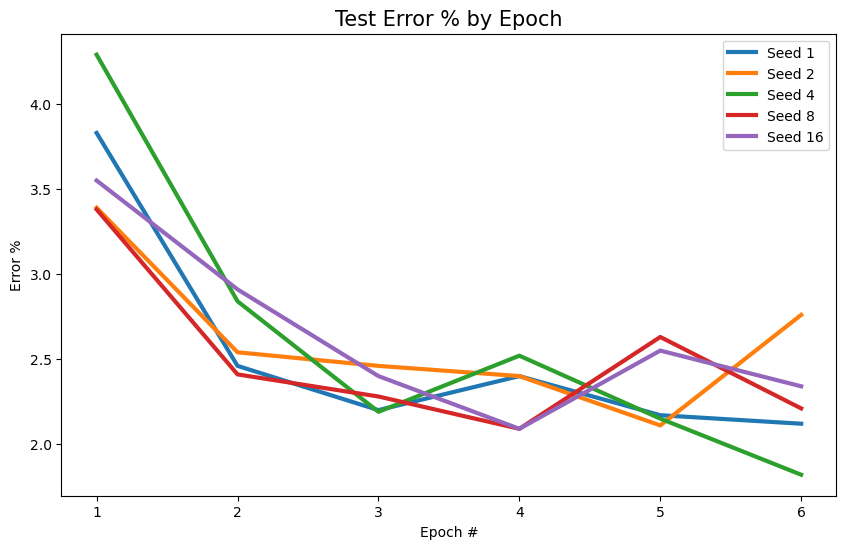

In [12]:
# print(f"Test error obtained after training has finished: {test_error_by_epoch[-1]*100:.3f} %")

for (index, test_errors) in enumerate(test_errors_by_run):
	# plt.plot(range(1, len(train_error_by_epoch)+1), np.array(train_error_by_epoch)*100, label="Train")
	plt.plot(range(1, len(test_errors)+1), np.array(test_errors)*100, label=f"Seed {SEEDS[index]}")

# print(train_error_by_epoch)
# print(test_error_by_epoch)

plt.title("Test Error % by Epoch", fontsize=15)
plt.xlabel('Epoch #')
plt.ylabel('Error %')
plt.legend()
plt.show()

In [21]:
test_errors_by_run
# test_errors_by_run = np.array(test_errors_by_run) * 100
# final_errors = test_errors_by_run[:,-1]
# np.mean(final_errors)
# # np.std(final_errors)

array([[3.83e+12, 2.46e+12, 2.20e+12, 2.40e+12, 2.17e+12, 2.12e+12],
       [3.39e+12, 2.54e+12, 2.46e+12, 2.40e+12, 2.11e+12, 2.76e+12],
       [4.29e+12, 2.84e+12, 2.19e+12, 2.52e+12, 2.15e+12, 1.82e+12],
       [3.38e+12, 2.41e+12, 2.28e+12, 2.09e+12, 2.63e+12, 2.21e+12],
       [3.55e+12, 2.91e+12, 2.40e+12, 2.09e+12, 2.55e+12, 2.34e+12]])